In [4]:
# Let's start off by importing the relevant libraries
import pandas as pd
import numpy as np
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

# Loading data

In [5]:
# Import raw data
def import_data():
    df = pd.read_csv("gimmer.csv", header=0) # creates a Pandas data frame for input value
    df.head()
    df['date'] = df['TIMESTAMP']
    df = df.drop(columns=['TIMESTAMP'])
    df.head()
    return df

In [6]:
raw_data_df = import_data()
raw_data_df.head()

,status,avgMeasuredTime,avgSpeed,extID,medianMeasuredTime,vehicleCount,_id,REPORT_ID,date
0,OK,66,56,668,66,7,190000,158324,2014-02-13T11:30:00
1,OK,69,53,668,69,5,190449,158324,2014-02-13T11:35:00
2,OK,69,53,668,69,6,190898,158324,2014-02-13T11:40:00
3,OK,70,52,668,70,3,191347,158324,2014-02-13T11:45:00
4,OK,64,57,668,64,6,191796,158324,2014-02-13T11:50:00


In [7]:
label = 'vehicleCount'
result=raw_data_df
result['date']=pd.to_datetime(result['date'])
data=result.loc[:, [label]]
data = data.set_index(result.date)
data[label] = pd.to_numeric(data[label],downcast='float',errors='coerce')

In [8]:
data.head()

,vehicleCount
date,
2014-02-13 11:30:00,7.0
2014-02-13 11:35:00,5.0
2014-02-13 11:40:00,6.0
2014-02-13 11:45:00,3.0
2014-02-13 11:50:00,6.0


In [9]:
data.dropna().describe()

,vehicleCount
count,4.529241e+06
mean,5.292092e+00
std,7.721745e+00
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+00
75%,7.000000e+00
max,1.210000e+02


## Resampling

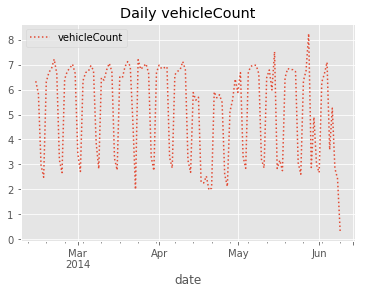

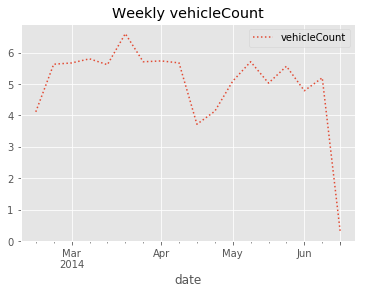

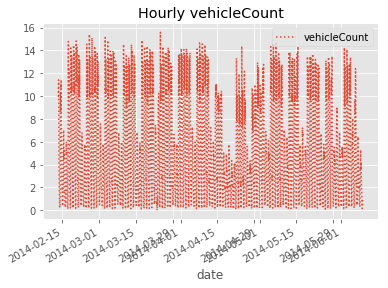

In [10]:
label = 'vehicleCount'
daily = data.resample('D').mean()
daily.dropna(inplace=True)
daily.plot(style=[':', '--', '-'],
           title='Daily '+label)

weekly = data.resample('W').mean()
weekly.dropna(inplace=True)
weekly.plot(style=[':', '--', '-'],
            title='Weekly '+label)

hourly = data.resample('H').mean()
hourly.dropna(inplace=True)
hourly.plot(style=[':', '--', '-'],
            title='Hourly '+label)

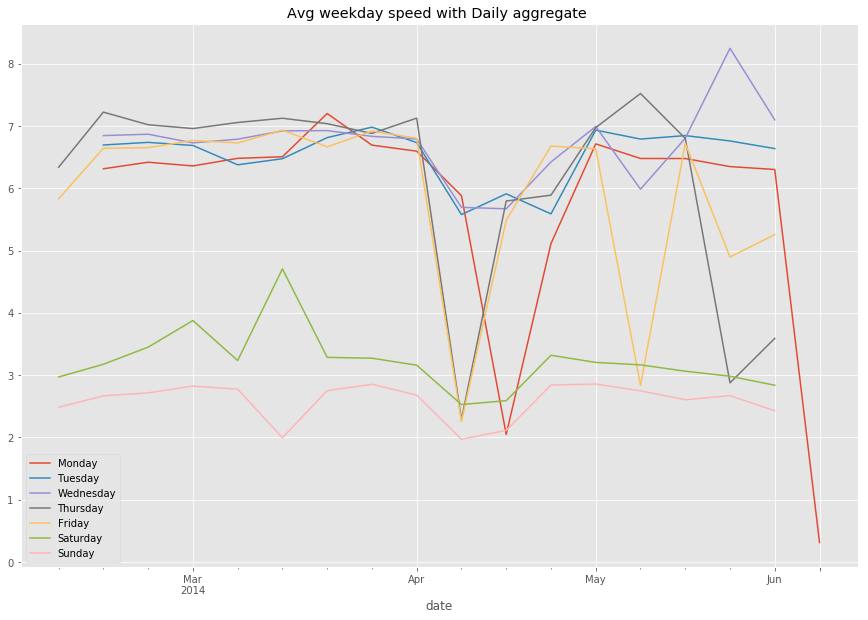

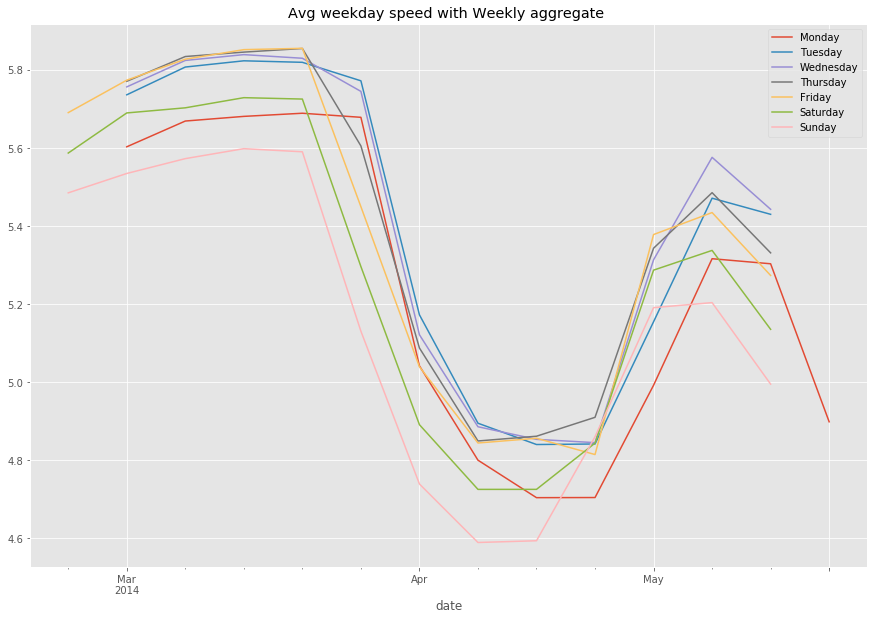

In [11]:
plt.rcParams['figure.figsize'] = (15, 10)
ts = data.resample('D').mean()
ts['weekday'] = ts.index.weekday
fig, ax = plt.subplots()
ts.groupby('weekday').agg(lambda x: x[label].plot(ax=ax,
                                                       legend=True,
                                                       label=x.index.weekday_name[0]))
plt.title("Avg weekday speed with Daily aggregate ")
plt.show()

ts = daily.rolling(30, center=True).mean()
ts['weekday'] = ts.index.weekday
fig, ax = plt.subplots()
ts.groupby('weekday').agg(lambda x: x[label].plot(ax=ax,
                                                       legend=True,
                                                       label=x.index.weekday_name[0]))
plt.title("Avg weekday speed with Weekly aggregate ")
plt.show()

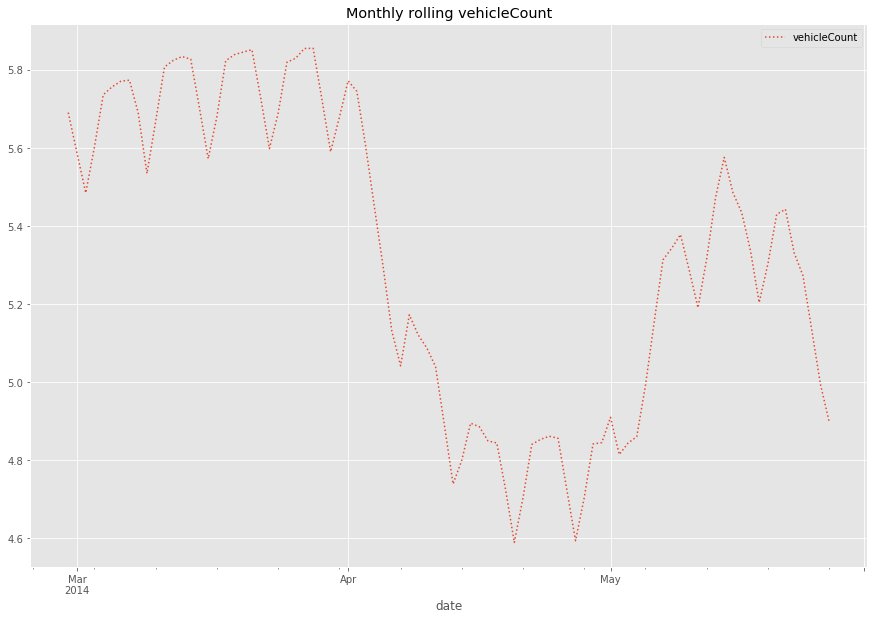

In [12]:
daily = data.resample('D').mean()
daily.rolling(30, center=True).mean().plot(style=[':', '--', '-'],
                                           title='Monthly rolling '+label)


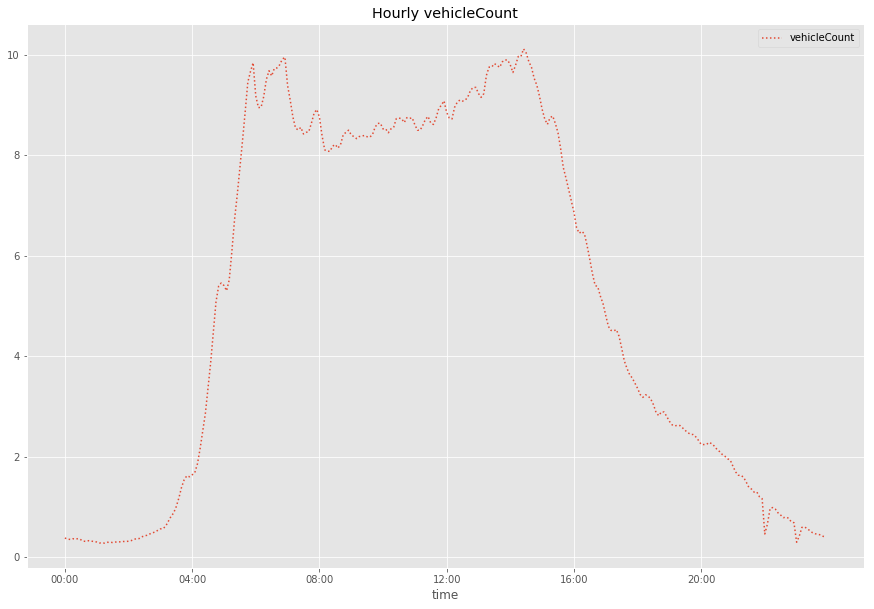

In [13]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-'],
            title="Hourly "+label);

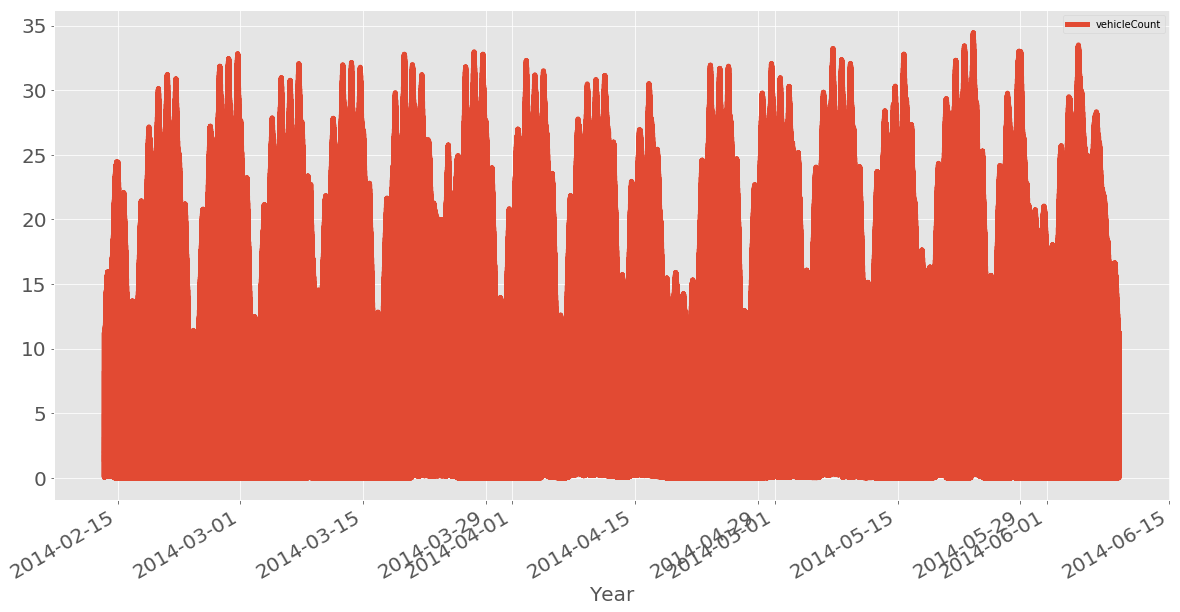

In [14]:
data.rolling(360).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

## Additional explorations

In [15]:
df = raw_data_df.loc[:,['date', label]]
df[label]=pd.to_numeric(df[label],errors='coerce')
df = df.groupby(['date']).mean().reset_index()
df.head()

,date,vehicleCount
0,2014-02-13 11:30:00,10.280000
1,2014-02-13 11:35:00,10.060000
2,2014-02-13 11:40:00,10.473333
3,2014-02-13 11:45:00,10.040000
4,2014-02-13 11:50:00,9.166667


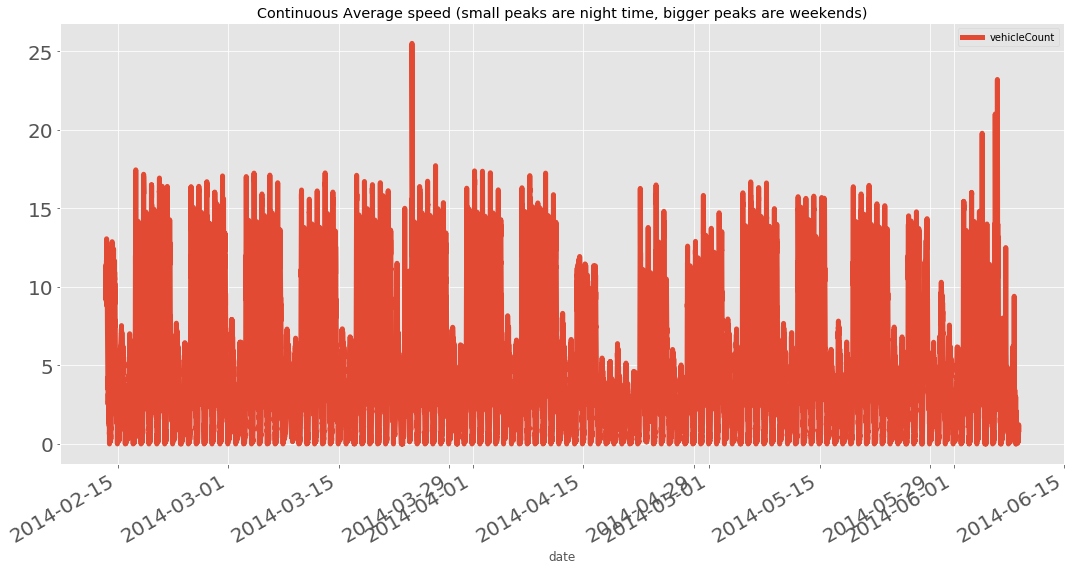

In [16]:
df.plot.line(x = 'date', y = label,  figsize=(18,9), linewidth=5, fontsize=20)
plt.title("Continuous Average speed (small peaks are night time, bigger peaks are weekends)")
plt.show()

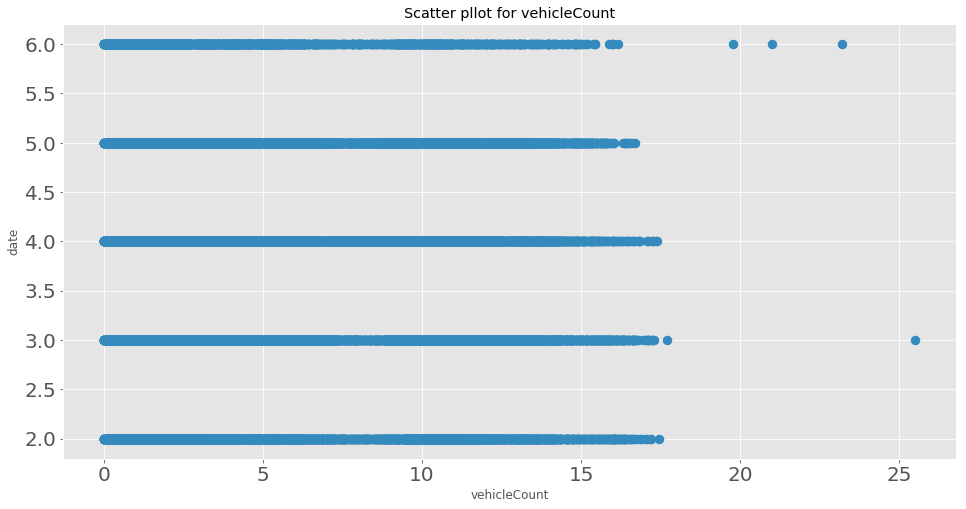

In [17]:
mon = df['date']
temp= pd.DatetimeIndex(mon)
month = pd.Series(temp.month)
to_be_plotted  = df.drop(['date'], axis = 1)
to_be_plotted = to_be_plotted.join(month)
to_be_plotted.plot.scatter(x = label, y = 'date', figsize=(16,8), linewidth=5, fontsize=20)
plt.title('Scatter pllot for '+label)
plt.show()

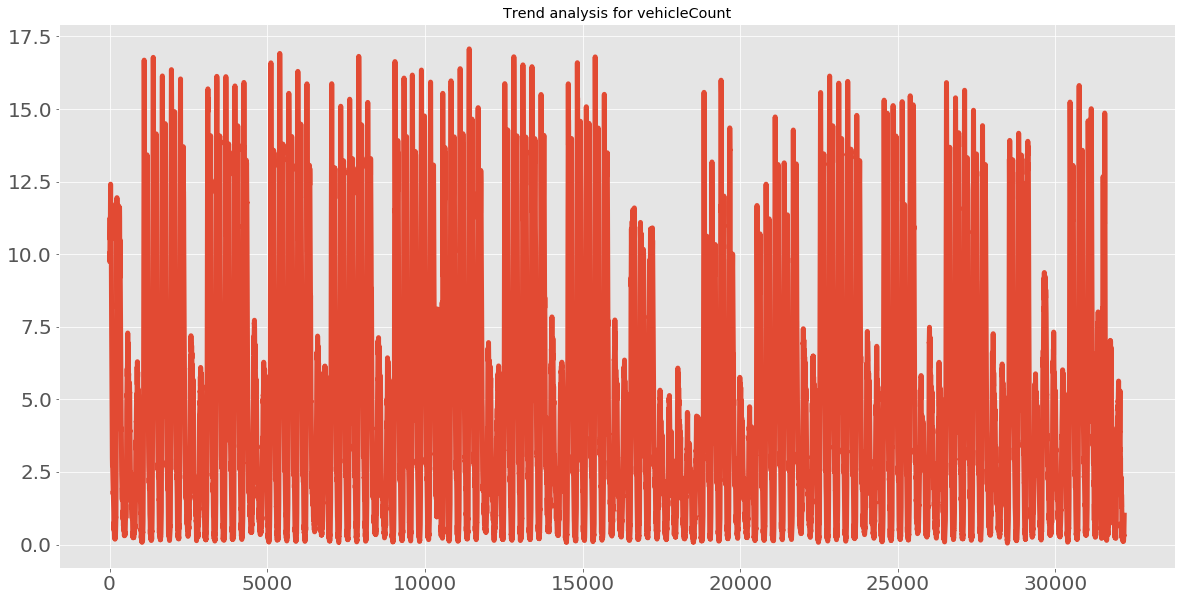

In [18]:
plt.title("Trend analysis for "+label)
df[label].rolling(5).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

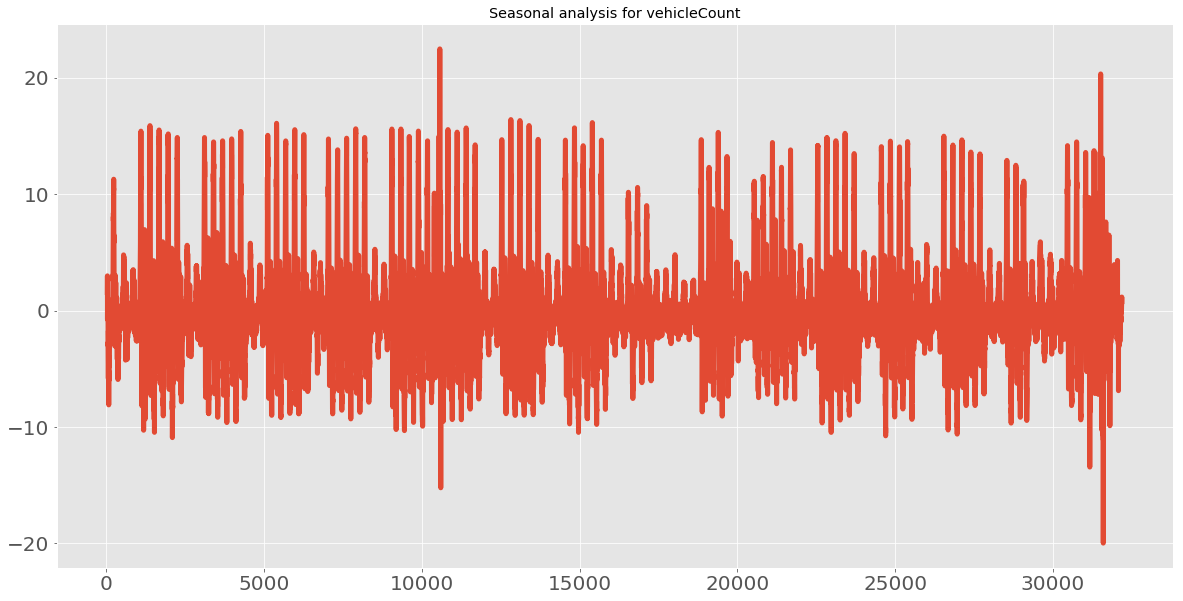

In [19]:
plt.title("Seasonal analysis for "+label)
df[label].diff(periods=30).plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.show()

/home/enigmaeth/miniconda3/envs/tf/lib/python3.6/site-packages/matplotlib/pyplot.py:934: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


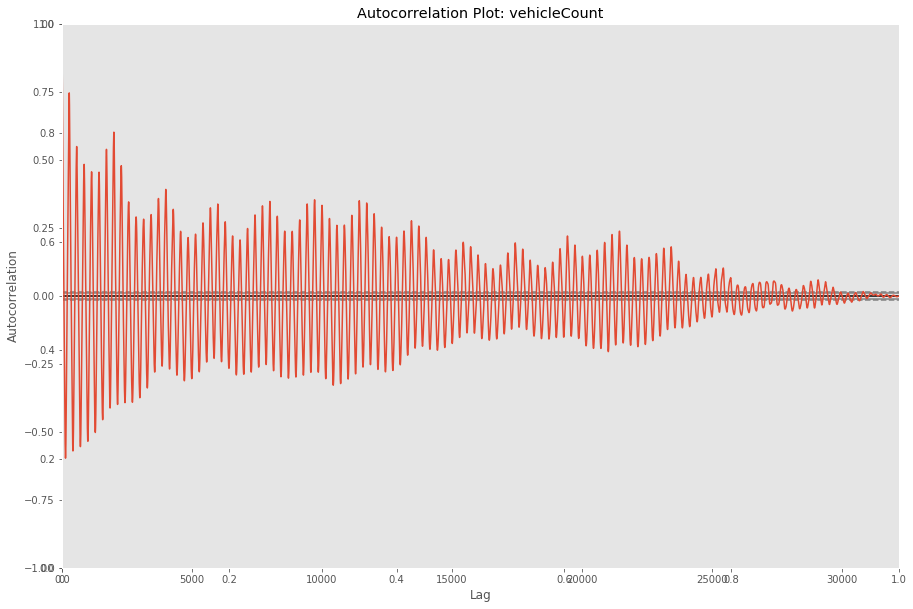

In [20]:
plt.title("Autocorrelation Plot: "+label)
pd.plotting.autocorrelation_plot(df[label])
plt.show()

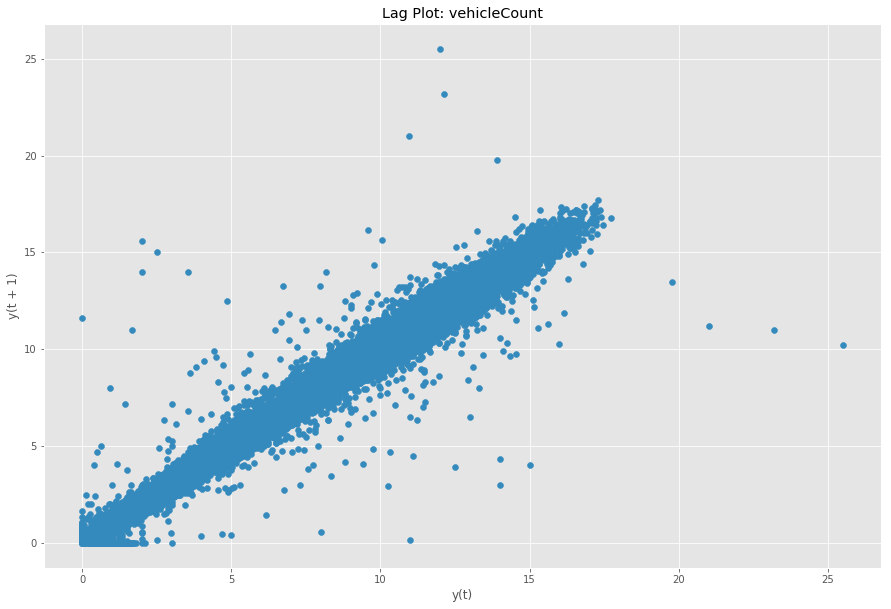

In [21]:
plt.title("Lag Plot: "+label)
pd.plotting.lag_plot(df[label])
plt.show()

# LSTM prediction

In [22]:
data_ = hourly
mydata=data_.loc[:, [label]]
mydata = mydata.set_index(data_.index)
mydata.head()
mydata.shape

(2745, 1)

In [23]:
#Use MinMaxScaler to normalize 'KWH/hh (per half hour) ' to range from 0 to 1
from sklearn.preprocessing import MinMaxScaler
values = mydata[label].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [24]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

2196 549


In [25]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [26]:
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2191
544


In [27]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=30, batch_size=10, validation_data=(testX, testY), verbose=1, shuffle=False)

/home/enigmaeth/miniconda3/envs/tf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 2191 samples, validate on 544 samples
Epoch 1/30
2191/2191 [==============================] - 14s 6ms/step - loss: 0.1400 - val_loss: 0.0842
Epoch 2/30
2191/2191 [==============================] - 2s 748us/step - loss: 0.0838 - val_loss: 0.0622
Epoch 3/30
2191/2191 [==============================] - 2s 761us/step - loss: 0.0685 - val_loss: 0.0544
Epoch 4/30
2191/2191 [==============================] - 2s 750us/step - loss: 0.0642 - val_loss: 0.0516
Epoch 5/30
2191/2191 [==============================] - 2s 893us/step - loss: 0.0614 - val_loss: 0.0501
Epoch 6/30
2191/2191 [==============================] - 2s 964us/step - loss: 0.0589 - val_loss: 0.0481
Epoch 7/30
2191/2191 [==============================] - 2s 816us/step - loss: 0.0567 - val_loss: 0.0467
Epoch 8/30
2191/2191 [==============================] - 2s 918us/step - loss: 0.0548 - val_loss: 0.0457
Epoch 9/30
2191/2191 [==============================] - 2s 830us/step - loss: 0.0535 - val_loss: 0.0462
Epoch 10/30
2191/2

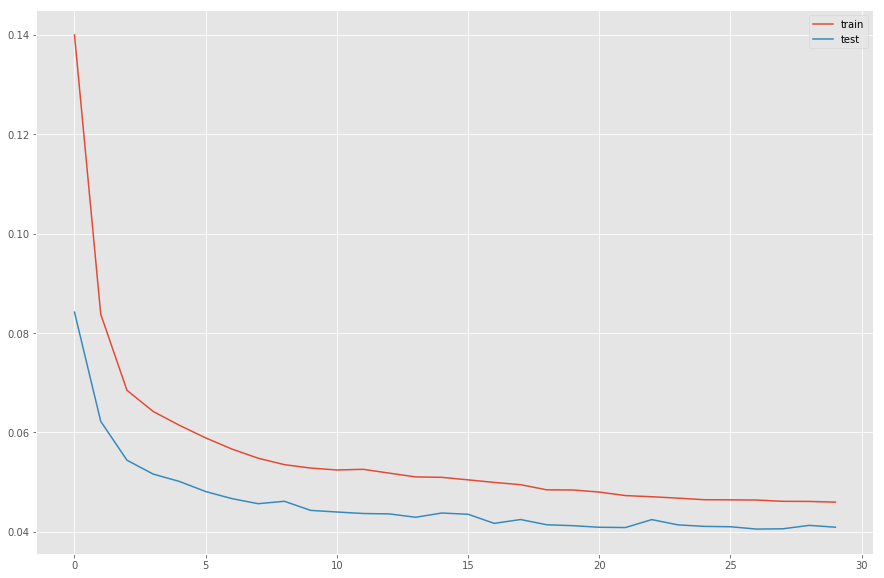

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

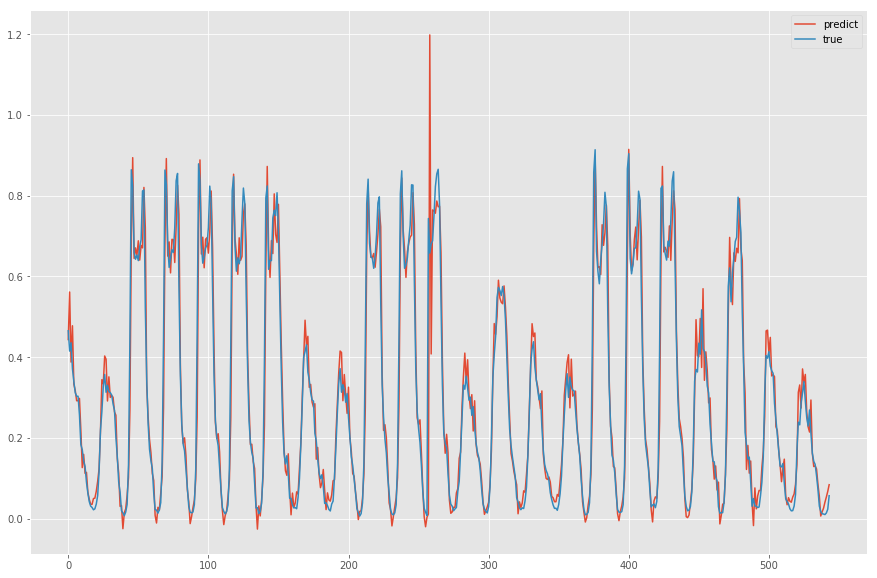

In [30]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()

In [31]:
from math import sqrt
from sklearn.metrics import mean_squared_error
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.078


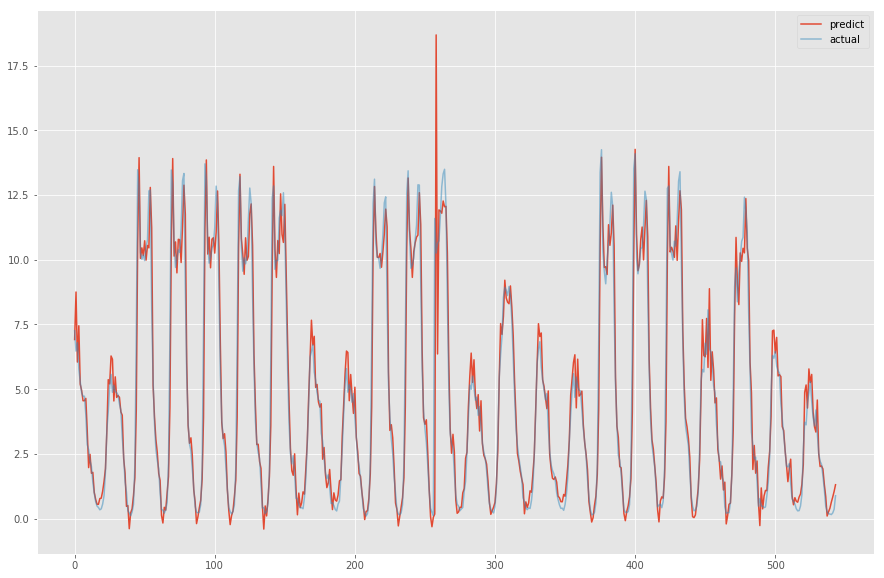

In [32]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()

# Clustering

In [33]:
raw_data_df['date']=pd.to_datetime(raw_data_df['date'])
raw_data_df['dy']=raw_data_df['date'].dt.dayofyear
raw_data_df['heure']=raw_data_df['date'].dt.time
data_2014=raw_data_df.loc[:, ['heure','dy',label]]
temp=raw_data_df.loc[:, ['dy',label]]
data_2014[label]=pd.to_numeric(data_2014[label],errors='coerce')
temp=temp.set_index(data_2014.heure)
temp=data_2014.pivot_table(index=['heure'],columns=['dy'] ,values=[label],fill_value=0)

temp.head()

vehicleCount                                                    \
dy                44        45        46        47        48        49    
heure                                                                     
00:00:00          0.0  0.271739  0.561798  0.966667  0.133333  0.253333   
00:05:00          0.0  0.228261  0.586957  0.820000  0.153333  0.186667   
00:10:00          0.0  0.193548  0.756757  0.000000  0.173333  0.166667   
00:15:00          0.0  0.202247  1.088235  0.926667  0.113333  0.246667   
00:20:00          0.0  0.397590  0.827273  0.646667  0.086667  0.160000   

                                                    ...               \
dy             50        51        52        53     ...          151   
heure                                               ...                
00:00:00  0.305263  0.500000  0.286885  1.111111    ...     0.313333   
00:05:00  0.373737  0.370787  0.229167  0.972973    ...     0.386667   
00:10:00  0.370787  0.361702  0.309278  0.853933    ...     0.480000   
00:15:00  0.506173  0.369565  0.363636  0.905405    ...     0.460000   
00:20:00  0.427083  0.245763  0.274725  0.746479    ...     0.433333   

                                                                           \
dy             152       153       154       155       156       157  158   
heure                                                                       
00:00:00  0.506667  0.186667  0.293333  0.560000  0.253333  0.306667  0.0   
00:05:00  0.346667  0.193333  0.160000  0.876712  0.285714  0.246667  0.0   
00:10:00  0.446667  0.160000  0.160000  0.806667  0.000000  0.000000  0.0   
00:15:00  0.580000  0.100000  0.326667  0.793333  0.453333  0.000000  1.0   
00:20:00  0.626667  0.133333  0.380000  0.820000  0.333333  0.000000  0.0   

                              
dy             159       160  
heure                         
00:00:00  1.333333  0.256410  
00:05:00  0.000000  0.308725  
00:10:00  0.666667  0.220000  
00:15:00  0.933333  0.193333  
00:20:00  0.573333  0.256410  

[5 rows x 117 columns]

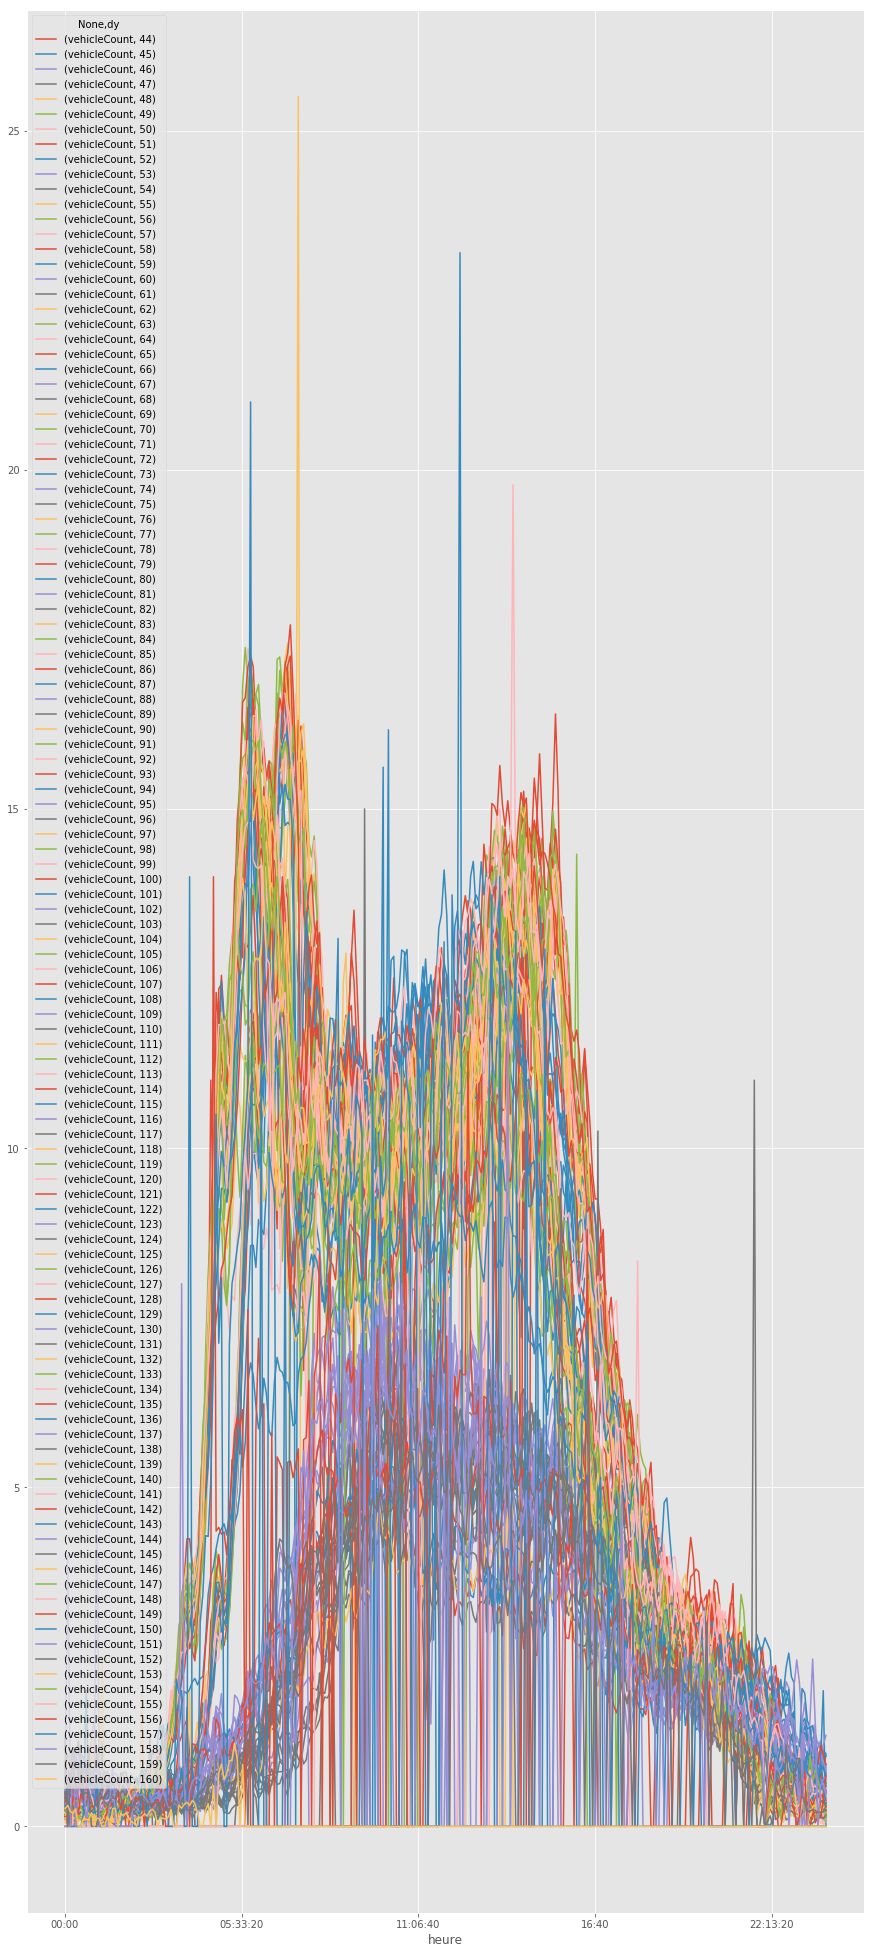

In [34]:
temp.plot(figsize=(15, 35))

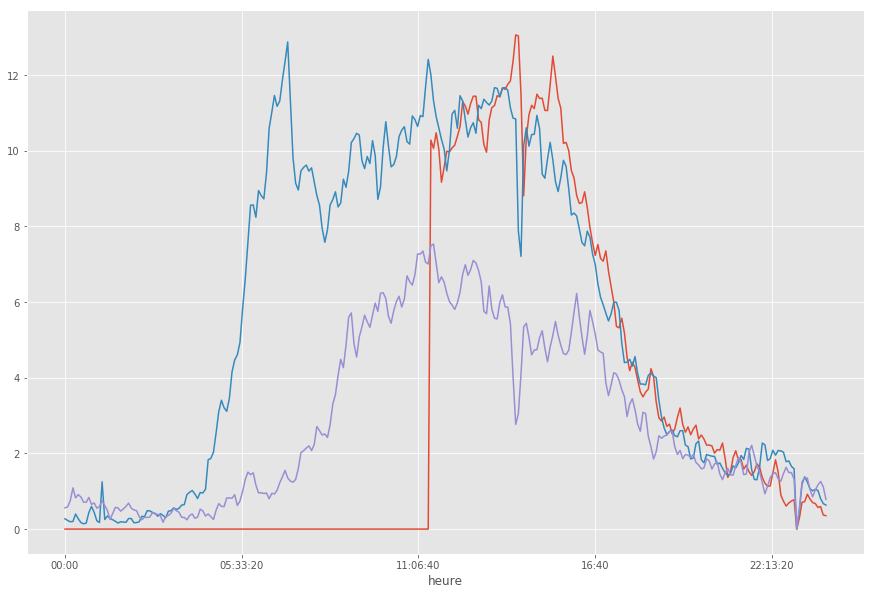

In [35]:
temp.iloc[:,0].plot(x=temp.index.get_level_values)
temp.iloc[:,1].plot(x=temp.index.get_level_values)
temp.iloc[:,2].plot(x=temp.index.get_level_values)

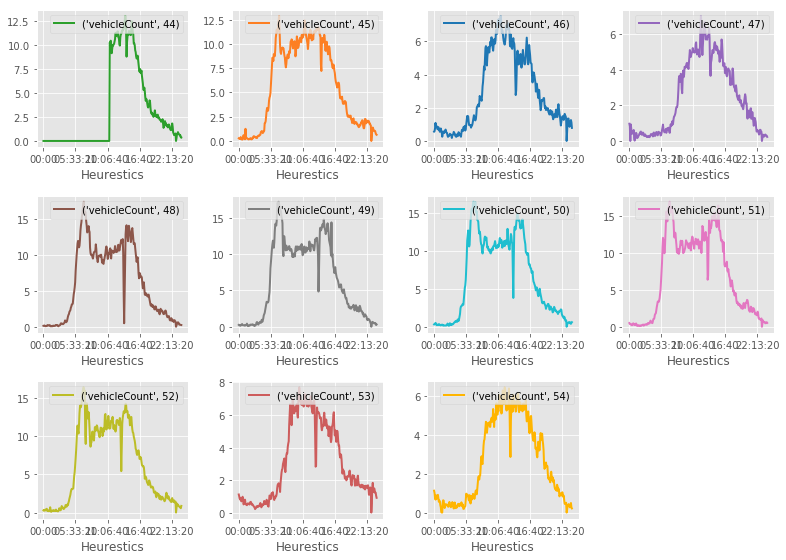

In [36]:
plt.figure(figsize=(11,10))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27',
          '#CD5C5C',"#FFB500"]

for i, r in enumerate([0,1,2,3,4,5,6,7,8,9,10],1):
     
    plt.subplot(4,4,i)
    plt.plot(temp.iloc[:,r],  color=colors[i], linewidth=2)
    plt.xlabel('Heurestics')
    plt.legend(loc='upper right')
    plt.tight_layout()

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(temp.iloc[:,0:365], 'ward')

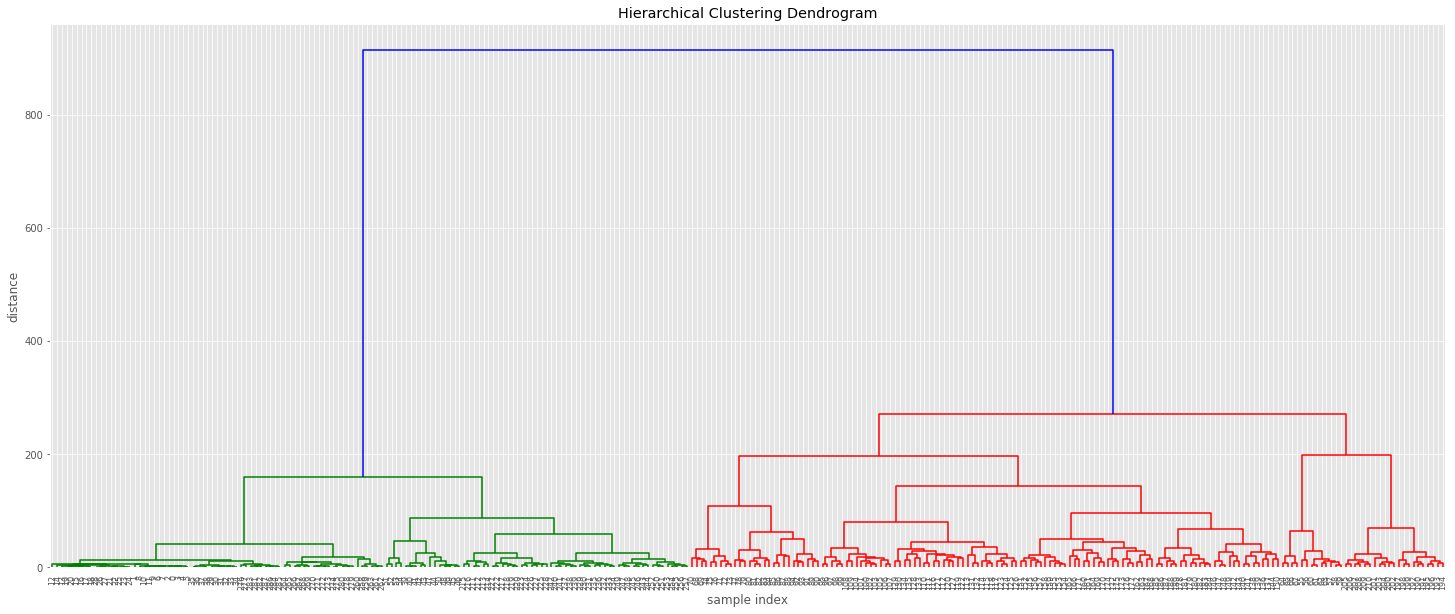

In [38]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

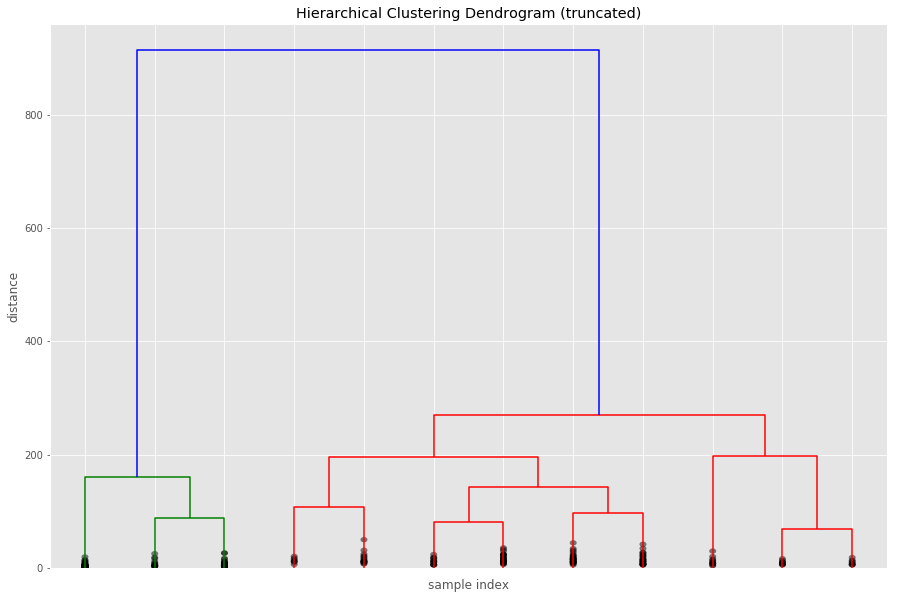

In [39]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()